In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
# Note: matplotlib.colors.CenteredNorm requires matplotlib version >= 3.4.0

from astropy import units as u

from astropy.time import Time
from astropy.coordinates import SkyCoord

from astropy.visualization import quantity_support, time_support

from scipy.optimize import curve_fit

In [2]:
quantity_support()
time_support(format='iso')

%matplotlib inline

In [3]:
obs_style = {
    'linestyle': 'none',
    'color': 'grey',
    'marker': 'o',
    'markerfacecolor': 'none'
}

mdl_style = {
    'linestyle': '-',
    'linewidth': 2,
    'color': 'C0'
}

dveff_lbl = (r'scaled effective velocity '
             r'$\dfrac{ | v_\mathrm{eff,\!\!\parallel} | }'
             r'{ \sqrt{ d_\mathrm{eff} } }$ '
             r'$\left( \dfrac{ \mathrm{km/s} }'
             r'{ \sqrt{ \mathrm{pc} } } \right)$')

dveff_signed_lbl = (r'scaled effective velocity '
                    r'$\dfrac{ v_\mathrm{eff,\!\!\parallel} }'
                    r'{ \sqrt{ d_\mathrm{eff} } }$ '
                    r'$\left( \dfrac{ \mathrm{km/s} }'
                    r'{ \sqrt{ \mathrm{pc} } } \right)$')

title_kwargs = {
    'loc': 'left',
    'x': 0.01,
    'y': 1.0,
    'pad': -14
}

In [4]:
p_orb_p = 5.7410459 * u.day
t_asc_p = Time(54501.4671, format='mjd', scale='tdb')

In [5]:
p_orb_e = 1. * u.yr
t_eqx = Time('2005-03-21 12:33', format='iso', scale='utc')

psr_coord = SkyCoord('04h37m15.99744s -47d15m09.7170s')

psr_coord_eclip = psr_coord.barycentricmeanecliptic

t_asc_e = t_eqx + (psr_coord_eclip.lon + 90.*u.deg).to_value(u.cycle) * p_orb_e

In [6]:
data = np.load('./data/fake-data-J0437.npz')

t_obs = Time(data['t_mjd'], format='mjd', scale='utc')
dveff_obs = data['dveff_obs'] * u.km/u.s/u.pc**0.5
dveff_err = data['dveff_err'] * u.km/u.s/u.pc**0.5

In [7]:
ph_e_obs = ((t_obs - t_asc_e) / p_orb_e).to(u.dimensionless_unscaled) * u.cycle
ph_p_obs = ((t_obs - t_asc_p) / p_orb_p).to(u.dimensionless_unscaled) * u.cycle

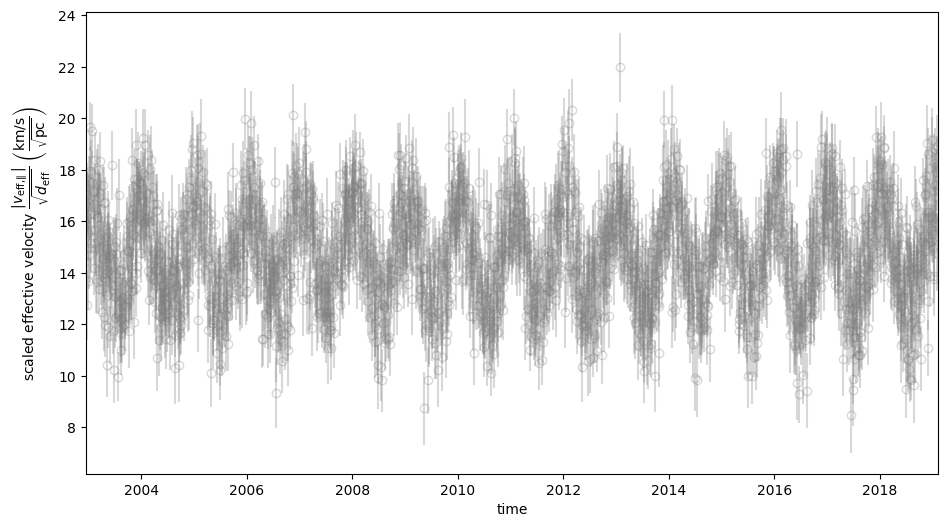

In [8]:
plt.figure(figsize=(11., 6.))

plt.errorbar(t_obs.jyear, dveff_obs, yerr=dveff_err, **obs_style, alpha=0.3)

plt.xlim(t_obs[0].jyear, t_obs[-1].jyear)

plt.xlabel('time')
plt.ylabel(dveff_lbl)

plt.show()

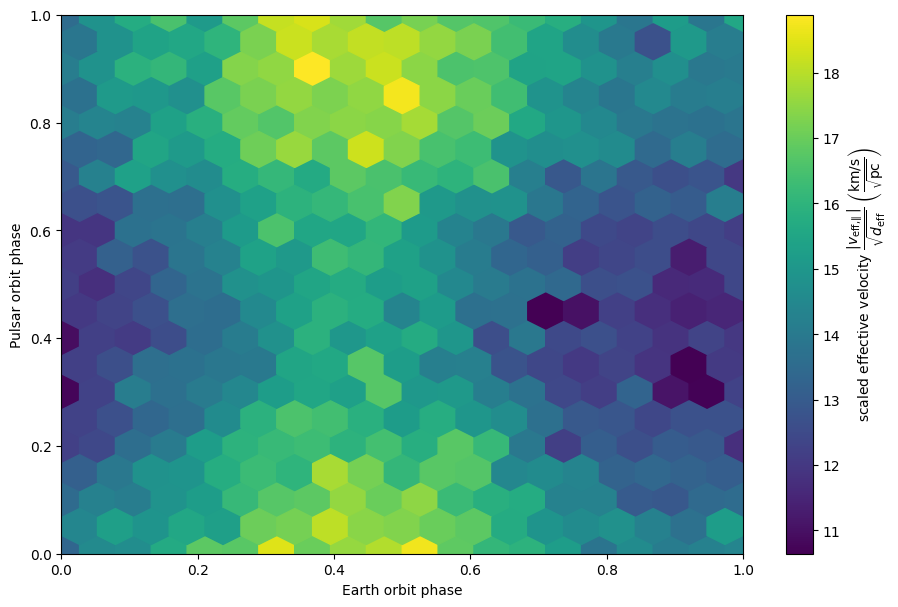

In [9]:
plt.figure(figsize=(11., 7.))

plt.hexbin(ph_e_obs.value % 1., ph_p_obs.value % 1., C=dveff_obs.value,
           reduce_C_function=np.median, gridsize=19)

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xlabel('Earth orbit phase')
plt.ylabel('Pulsar orbit phase')

cbar = plt.colorbar()
cbar.set_label(dveff_lbl)

In [10]:
def model_dveff_signed(pars, t):

    ph_e = ((t - t_asc_e) / p_orb_e).to(u.dimensionless_unscaled) * u.cycle
    ph_p = ((t - t_asc_p) / p_orb_p).to(u.dimensionless_unscaled) * u.cycle

    dveff_e = pars['amp_e'] * np.sin(ph_e - pars['chi_e'])
    dveff_p = pars['amp_p'] * np.sin(ph_p - pars['chi_p'])

    dveff = dveff_e + dveff_p + pars['dveff_c']

    return (dveff).to(u.km/u.s/u.pc**0.5)

def model_dveff_abs(pars, t):
    dveff_signed = model_dveff_signed(pars, t)
    return np.abs(dveff_signed)

In [11]:
pars_try = {
    'amp_e':     2.  * u.km/u.s/u.pc**0.5,
    'amp_p':     1.5 * u.km/u.s/u.pc**0.5,
    'chi_e':    54.  * u.deg,
    'chi_p':   234.  * u.deg,
    'dveff_c':  15.  * u.km/u.s/u.pc**0.5
}

In [12]:
def visualize_model_full(pars):

    dveff_mdl = model_dveff_abs(pars, t_obs)
    dveff_res = dveff_obs - dveff_mdl

    tlim_long = [t_obs[0].mjd, t_obs[0].mjd + 3. * p_orb_e.to_value(u.day)]
    tlim_zoom = [t_obs[0].mjd, t_obs[0].mjd + 5. * p_orb_p.to_value(u.day)]

    t_mjd_many = np.arange(tlim_long[0], tlim_long[-1], 0.2)
    t_many = Time(t_mjd_many, format='mjd')

    dveff_mdl_many = model_dveff_abs(pars, t_many)

    plt.figure(figsize=(10., 7.5))

    plt.subplots_adjust(wspace=0.1)

    ax1 = plt.subplot(221)
    plt.plot(t_many, dveff_mdl_many, **mdl_style, alpha=0.3)
    plt.errorbar(t_obs.mjd, dveff_obs, yerr=dveff_err, **obs_style, alpha=0.3)
    plt.xlim(tlim_long)
    plt.title('full model', **title_kwargs)
    plt.xlabel('')
    plt.ylabel(dveff_lbl)

    ax2 = plt.subplot(223, sharex=ax1)
    plt.errorbar(t_obs.mjd, dveff_res, yerr=dveff_err, **obs_style, alpha=0.3)
    plt.axhline(**mdl_style)
    plt.xlim(tlim_long)
    plt.title('residuals', **title_kwargs)
    plt.ylabel(dveff_signed_lbl)

    ax3 = plt.subplot(222, sharey=ax1)
    plt.plot(t_many, dveff_mdl_many, **mdl_style)
    plt.errorbar(t_obs.mjd, dveff_obs, yerr=dveff_err, **obs_style)
    plt.xlim(tlim_zoom)
    plt.title('full model, zoom', **title_kwargs)
    plt.xlabel('')
    plt.ylabel(dveff_lbl)
    ax3.yaxis.set_label_position('right')
    ax3.yaxis.tick_right()

    ax4 = plt.subplot(224, sharex=ax3, sharey=ax2)
    plt.errorbar(t_obs.mjd, dveff_res, yerr=dveff_err, **obs_style)
    plt.axhline(**mdl_style)
    plt.xlim(tlim_zoom)
    plt.title('residuals, zoom', **title_kwargs)
    plt.ylabel(dveff_signed_lbl)
    ax4.yaxis.set_label_position('right')
    ax4.yaxis.tick_right()

    plt.show()

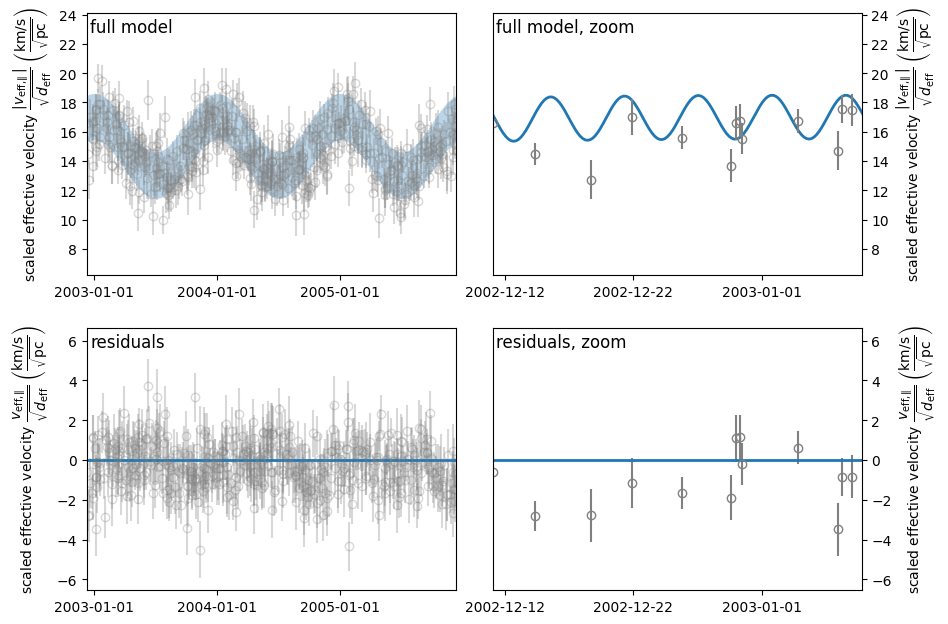

In [13]:
visualize_model_full(pars_try)

In [14]:
def visualize_model_folded(pars):

    dveff_mdl_full = model_dveff_abs(pars, t_obs)

    pars_earth = pars.copy()
    pars_earth['amp_p'] = 0. * u.km/u.s/u.pc**0.5
    pars_earth['dveff_c'] = 0. * u.km/u.s/u.pc**0.5
    dveff_mdl_earth = model_dveff_signed(pars_earth, t_obs)

    pars_psr = pars.copy()
    pars_psr['amp_e'] = 0. * u.km/u.s/u.pc**0.5
    pars_psr['dveff_c'] = 0. * u.km/u.s/u.pc**0.5
    dveff_mdl_psr = model_dveff_signed(pars_psr, t_obs)

    dveff_res_earth = dveff_obs - dveff_mdl_full + dveff_mdl_earth
    dveff_res_psr = dveff_obs - dveff_mdl_full + dveff_mdl_psr

    plt.figure(figsize=(10., 4.))

    plt.subplots_adjust(wspace=0.1)

    ax1 = plt.subplot(121)
    idx_e = np.argsort(ph_e_obs.value % 1.)
    plt.plot(ph_e_obs[idx_e].value % 1., dveff_mdl_earth[idx_e], **mdl_style)
    plt.errorbar(ph_e_obs.value % 1., dveff_res_earth, yerr=dveff_err,
                 **obs_style, alpha=0.2, zorder=-3)
    plt.xlim(0., 1.)
    plt.title('Earth motion', **title_kwargs)
    plt.xlabel('Earth orbital phase')
    plt.ylabel(dveff_signed_lbl)

    ax2 = plt.subplot(122, sharey=ax1)
    idx_p = np.argsort(ph_p_obs.value % 1.)
    plt.plot(ph_p_obs[idx_p].value % 1., dveff_mdl_psr[idx_p], **mdl_style)
    plt.errorbar(ph_p_obs.value % 1., dveff_res_psr, yerr=dveff_err,
                 **obs_style, alpha=0.2, zorder=-3)
    plt.xlim(0., 1.)
    plt.title('Pulsar motion', **title_kwargs)
    plt.xlabel('Pulsar orbital phase')
    plt.ylabel(dveff_signed_lbl)
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()

    plt.show()

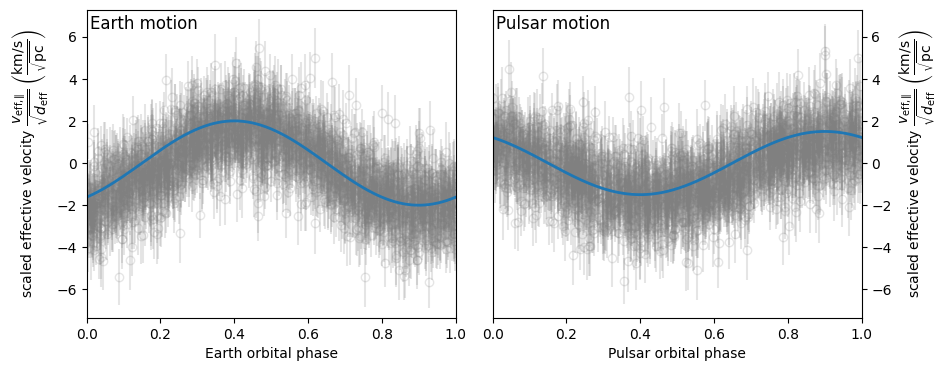

In [15]:
visualize_model_folded(pars_try)

In [16]:
def visualize_model_fold2d(pars):

    dveff_mdl = model_dveff_abs(pars, t_obs)
    dveff_res = dveff_obs - dveff_mdl

    plt.figure(figsize=(11.3, 4.))

    gridsize = 19
    labelpad = 16

    plt.subplot(131)
    plt.hexbin(ph_e_obs.value % 1., ph_p_obs.value % 1., C=dveff_obs.value,
               reduce_C_function=np.median, gridsize=gridsize)
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.xlabel('Earth orbit phase')
    plt.ylabel('Pulsar orbit phase')
    plt.title('data', **title_kwargs,
              fontdict={'color': 'w', 'fontweight': 'bold'})
    cbar = plt.colorbar(location='top')
    cbar.set_label(dveff_lbl, labelpad=labelpad)

    plt.subplot(132)
    plt.hexbin(ph_e_obs.value % 1., ph_p_obs.value % 1., C=dveff_mdl.value,
               reduce_C_function=np.median, gridsize=gridsize)
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.xlabel('Earth orbit phase')
    plt.title('model', **title_kwargs,
            fontdict={'color': 'w', 'fontweight': 'bold'})
    cbar = plt.colorbar(location='top')
    cbar.set_label(dveff_lbl, labelpad=labelpad)

    plt.subplot(133)
    plt.hexbin(ph_e_obs.value % 1., ph_p_obs.value % 1., C=dveff_res.value,
               reduce_C_function=np.median, gridsize=gridsize,
               norm=CenteredNorm(), cmap='coolwarm')
    # Note: CenteredNorm requires matplotlib version >= 3.4.0
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.xlabel('Earth orbit phase')
    plt.title('residuals', **title_kwargs,
              fontdict={'color': 'k', 'fontweight': 'bold'})
    cbar = plt.colorbar(location='top')
    cbar.set_label(dveff_signed_lbl, labelpad=labelpad)

    plt.show()

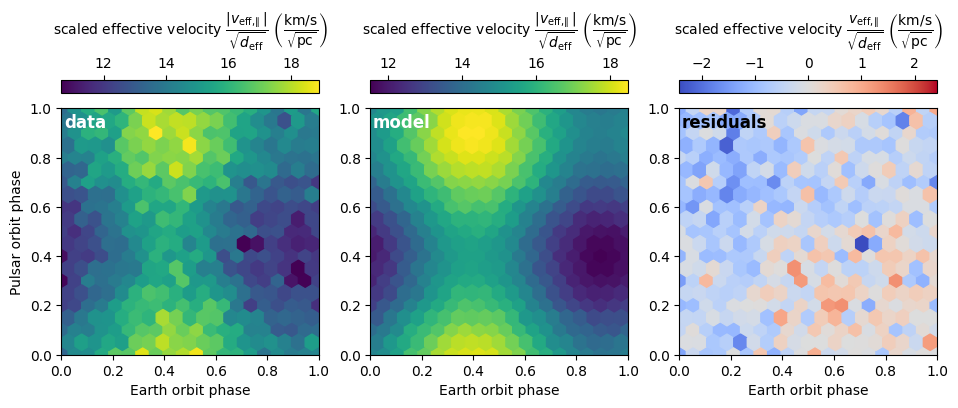

In [17]:
visualize_model_fold2d(pars_try)

In [18]:
def get_chi2(pars):
    dveff_mdl = model_dveff_abs(pars, t_obs)
    chi2 = np.sum(((dveff_obs - dveff_mdl) / dveff_err)**2)
    return chi2

In [19]:
chi2 = get_chi2(pars_try)
print(f'chi2     {chi2:8.2f}')

ndof = len(t_obs) - len(pars_try)
chi2_red = chi2 / ndof
print(f'chi2_red {chi2_red:8.2f}')

chi2      3174.65
chi2_red     1.20


In [20]:
def pars_mdl2fit(pars_mdl):

    amp_e = pars_mdl['amp_e'].to_value(u.km/u.s/u.pc**0.5)
    amp_p = pars_mdl['amp_p'].to_value(u.km/u.s/u.pc**0.5)
    chi_e = pars_mdl['chi_e'].to_value(u.rad)
    chi_p = pars_mdl['chi_p'].to_value(u.rad)
    dveff_c = pars_mdl['dveff_c'].to_value(u.km/u.s/u.pc**0.5)

    amp_es = amp_e * np.cos(chi_e)
    amp_ec = amp_e * np.sin(chi_e)
    amp_ps = amp_p * np.cos(chi_p)
    amp_pc = amp_p * np.sin(chi_p)

    pars_fit = np.array([amp_es, amp_ec, amp_ps, amp_pc, dveff_c])

    return pars_fit

def pars_fit2mdl(pars_fit):

    amp_es, amp_ec, amp_ps, amp_pc, dveff_c = pars_fit

    amp_e = np.sqrt(amp_es**2 + amp_ec**2)
    amp_p = np.sqrt(amp_ps**2 + amp_pc**2)
    chi_e = np.arctan2(amp_ec, amp_es)
    chi_p = np.arctan2(amp_pc, amp_ps)

    pars_mdl = {
        'amp_e': amp_e * u.km/u.s/u.pc**0.5,
        'amp_p': amp_p * u.km/u.s/u.pc**0.5,
        'chi_e': (chi_e * u.rad).to(u.deg) % (360.*u.deg),
        'chi_p': (chi_p * u.rad).to(u.deg) % (360.*u.deg),
        'dveff_c': dveff_c * u.km/u.s/u.pc**0.5,
    }

    return pars_mdl

In [21]:
sin_cos_ph_obs = np.array([
    np.sin(ph_e_obs).value,
    np.cos(ph_e_obs).value,
    np.sin(ph_p_obs).value,
    np.cos(ph_p_obs).value,
])

In [22]:
def model_dveff_fit(sin_cos_ph, *pars):

    amp_es, amp_ec, amp_ps, amp_pc, dveff_c = pars

    sin_ph_e = sin_cos_ph[0,:]
    cos_ph_e = sin_cos_ph[1,:]
    sin_ph_p = sin_cos_ph[2,:]
    cos_ph_p = sin_cos_ph[3,:]

    dveff_e = amp_es * sin_ph_e - amp_ec * cos_ph_e
    dveff_p = amp_ps * sin_ph_p - amp_pc * cos_ph_p

    dveff = np.abs(dveff_e + dveff_p + dveff_c)

    return dveff

In [23]:
init_guess = pars_mdl2fit(pars_try)

par_names = ['amp_es', 'amp_ec', 'amp_ps', 'amp_pc', 'dveff_c']
for (par_name, par_value) in zip(par_names, init_guess):
    print(f'{par_name:8s} {par_value:8.2f}')

amp_es       1.18
amp_ec       1.62
amp_ps      -0.88
amp_pc      -1.21
dveff_c     15.00


In [24]:
popt, pcov = curve_fit(model_dveff_fit, sin_cos_ph_obs, dveff_obs.value,
                       p0=init_guess, sigma=dveff_err.value)

In [25]:
par_names = ['amp_es', 'amp_ec', 'amp_ps', 'amp_pc', 'dveff_c']
for (par_name, par_value) in zip(par_names, popt):
    print(f'{par_name:8s} {par_value:8.2f}')

amp_es       0.80
amp_ec       1.73
amp_ps      -0.55
amp_pc      -1.22
dveff_c     14.67


In [26]:
pars_opt = pars_fit2mdl(popt)

for par_name in pars_opt:
    print(f'{par_name:8s} {pars_opt[par_name]:8.2f}')

amp_e        1.91 km / (pc(1/2) s)
amp_p        1.34 km / (pc(1/2) s)
chi_e       65.14 deg
chi_p      245.83 deg
dveff_c     14.67 km / (pc(1/2) s)


In [27]:
pars_alt = pars_opt.copy()
pars_alt['chi_e'] = (pars_alt['chi_e'] + 180.*u.deg) % (360.*u.deg)
pars_alt['chi_p'] = (pars_alt['chi_p'] + 180.*u.deg) % (360.*u.deg)
pars_alt['dveff_c'] = -1. * pars_alt['dveff_c']

for par_name in pars_alt:
    print(f'{par_name:8s} {pars_alt[par_name]:8.2f}')

amp_e        1.91 km / (pc(1/2) s)
amp_p        1.34 km / (pc(1/2) s)
chi_e      245.14 deg
chi_p       65.83 deg
dveff_c    -14.67 km / (pc(1/2) s)


In [28]:
chi2 = get_chi2(pars_opt)
chi2_red = chi2 / ndof

print(f'\nchi2     {chi2:8.2f}'
      f'\nchi2_red {chi2_red:8.2f}')


chi2      2598.80
chi2_red     0.98


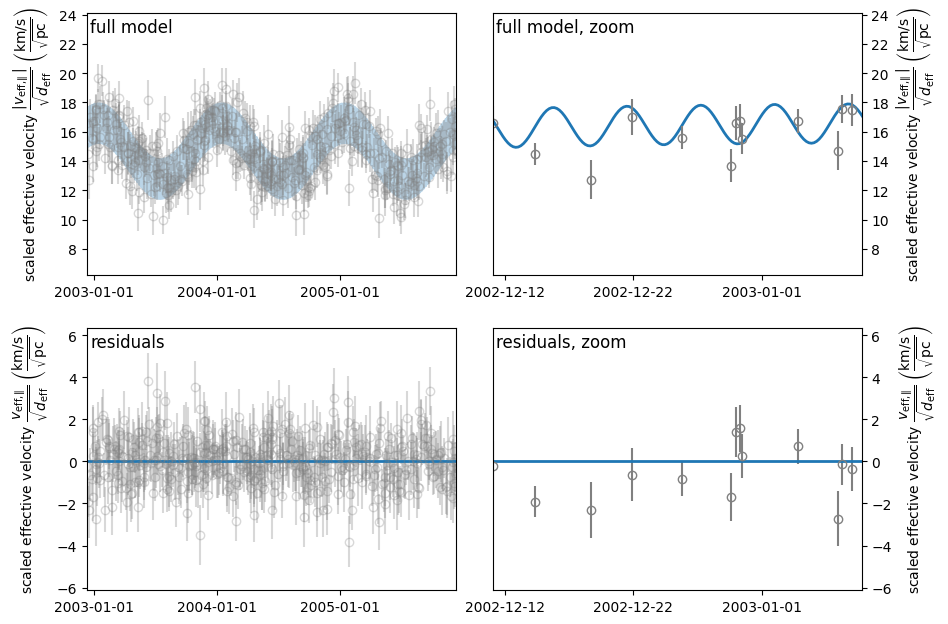

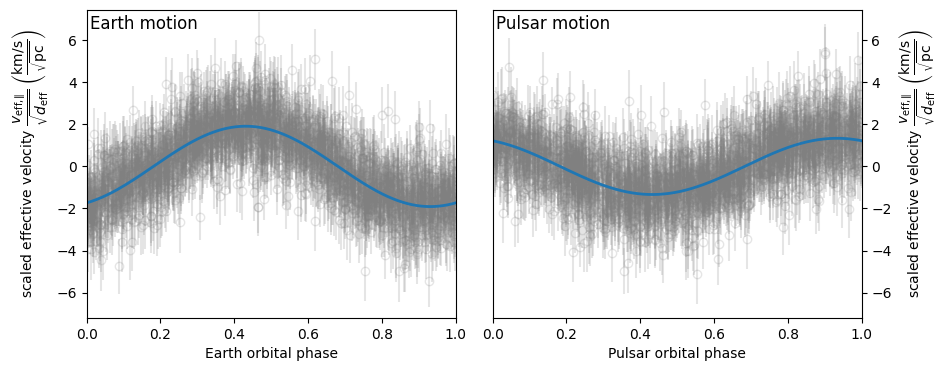

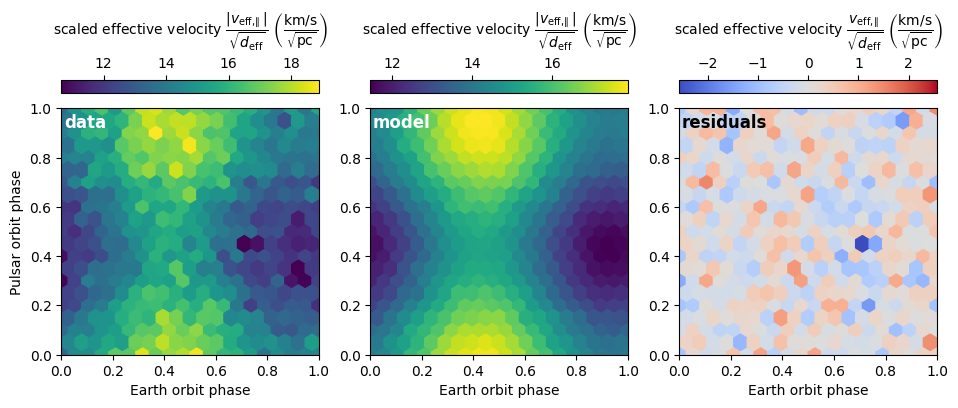

In [29]:
visualize_model_full(pars_opt)
visualize_model_folded(pars_opt)
visualize_model_fold2d(pars_opt)

In [ ]:
np.savez('data/fit-results-J0437.npz',
         popt=popt,
         pcov=pcov)